 
# Train Data Generation:
X = 32x32 images

Y = 16x16 images

In [ ]:
import numpy as np
import os
import cv2 as cv
import matplotlib.pyplot as plt
import more_itertools
from skimage.transform import resize
from PIL import Image

def zero_padding(img,k = (32,32)):
    #Zero Padding of an image in order to the size to be divisible by k.
    img_aux = img.copy()
    h,w,c = img_aux.shape
    if h%k[0]!=0:
        h_aux =k[0] - h%k[0]
    else:
        h_aux = 0
    h_add = np.asarray(h_aux*[w*[c*[1]]])
    if bool(h_add.any()):
        img_aux = np.concatenate((img_aux,h_add),axis = 0)
    h,w = img_aux.shape[0:2]
    if w%k[1]!=0:
        w_aux =k[1] - w%k[1]
    else:
        w_aux = 0
    w_add = np.asarray(h*[w_aux*[c*[1]]])

    if bool(w_add.any()):
        img_aux = np.concatenate((img_aux,w_add),axis = 1)
    return  img_aux 

def rolling_window(img,k=(32,32)):
    #Given an image it returns all the rolling windows of size k and stride k.
    img_aux = zero_padding(img,k)
    h,w = img_aux.shape[0:2]
    h_aux = range(h)
    w_aux = range(w)
    
    h_grid = np.asarray(list(more_itertools.windowed(h_aux,k[0],step= k[0])))    
    w_grid = np.asarray(list(more_itertools.windowed(w_aux,k[1],step= k[1])))    
    
    X = []
    for i in h_grid:
        for j in w_grid:
            X.append(img_aux[i[0]:i[-1]+1,j[0]:j[-1]+1,:])
    return X, h_grid.shape[0], w_grid.shape[0]

#Load Data
art = []
for img in os.listdir('ArtDataset'):
    if img != '.ipynb_checkpoints':
        art.append(cv.cvtColor(cv.imread('ArtDataset/'+img), cv.COLOR_BGR2RGB))

#Train Data generation
X = []
Y = []
for img in art:
  aux,_,_ = rolling_window(img,(32,32))
  for rw in aux:
    Y.append(rw)
    X_aux = Image.fromarray(np.int8(rw),'RGB')
    X_aux = X_aux.resize((16,16))
    X.append(np.asarray(X_aux))



## Data Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,Y , test_size=0.1, random_state=42)


#Unet Model

## Hyperameters of the Unet

In [ ]:
from keras import models
from keras.layers import Conv2D, Dropout, MaxPooling2D, UpSampling2D, Concatenate
from keras import optimizers
from keras.layers import Lambda, Input

n_train = len(X_train)
n_test = len(X_test)

num_rows, num_cols,num_channels = X_test[0].shape
img_dim          = (num_rows, num_cols, num_channels,)
filters_per_block = np.array([num_channels, 32, 64,128])
num_blocks        = len(filters_per_block)   
kernel_size       = (3,3)
drop              = 0.25*np.ones(num_blocks)

## Encoder



In [ ]:
nm= 'encoder'
Xdicc = {}
X_in  = Input(shape=img_dim, name="x_true")

X = X_in
Xdicc[0] = X_in
numFilters=filters_per_block[0]
print(0, numFilters, X.shape)

for i in range(1,num_blocks):
    numFilters=filters_per_block[i]
    X = Conv2D(numFilters, kernel_size=kernel_size, padding='same', activation='relu', name='encoder-conv1'+str(i))(X) 
    X = Conv2D(numFilters, kernel_size=kernel_size, padding='same', activation='relu', name='encoder-conv2'+str(i))(X)
    X = MaxPooling2D(pool_size=(2,2), padding='valid', name='encoder-maxpool'+str(i))(X)
    Xdicc[i] = X
    print(i, numFilters, Xdicc[i].shape) 
      

0 3 (None, 16, 16, 3)
1 32 (None, 8, 8, 32)
2 64 (None, 4, 4, 64)
3 128 (None, 2, 2, 128)


## Decoder


In [ ]:
Y=X
for i in range(num_blocks-1,0,-1):
    if i>1:
        numFilters = filters_per_block[i-1] 
    else:
        numFilters = 32
    Y = UpSampling2D(size=2, name='decoder-up'+str(i))(Y)  
    print(i, numFilters, Y.shape, Xdicc[i-1].shape)
    Y = Concatenate(name='decoder-concat'+str(i))([Y, Xdicc[i-1]])
    Y = Conv2D(numFilters, kernel_size=(3,3), padding='same', activation='relu', name='decoder-conv2'+str(i))(Y)
    Y = Conv2D(numFilters, kernel_size=(3,3), padding='same', activation='relu', name='decoder-conv3'+str(i))(Y)


3 64 (None, 4, 4, 128) (None, 4, 4, 64)
2 32 (None, 8, 8, 64) (None, 8, 8, 32)
1 32 (None, 16, 16, 32) (None, 16, 16, 3)


## Tail


In [ ]:
Y = UpSampling2D(size=2, name='tail-up'+str(i))(Y)  

Y = Conv2D(6, kernel_size=(3,3), 
           padding='same', 
           activation='relu',
           name='tail-2xch')(Y)
Y = Conv2D(3, kernel_size=(1,1), 
           padding='same', 
           activation='relu', 
           name='tail-last')(Y)



## Model

In [ ]:
import keras
from keras.layers import Input, Dense, Activation, Conv2D
from keras.layers import MaxPooling2D, Dropout, UpSampling2D
from keras.layers import BatchNormalization, Reshape
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.models import Sequential
from keras.utils.vis_utils import plot_model

import numpy as np
import matplotlib.pyplot as plt

def summary(model=None):

    header = '{:4} {:16} {:24} {:24} {:10}'.format('#', 'Layer Name','Layer Input Shape','Layer Output Shape','Parameters'
    )
    print('='*(len(header)))
    print(header)
    print('='*(len(header)))
    count=0
    count_trainable=0
    for i, layer in enumerate(model.layers):
        count_trainable += layer.count_params() if layer.trainable else 0
        input_shape = '{}'.format(layer.input_shape)
        output_shape = '{}'.format(layer.output_shape)
        str = '{:<4d} {:16} {:24} {:24} {:10}'.format(i,layer.name, input_shape, output_shape, layer.count_params())
        print(str)
        count += layer.count_params()
    print('_'*(len(header)))
    print('Total Parameters : ', count)
    print('Total Trainable Parameters : ', count_trainable)
    print('Total No-Trainable Parameters : ', count-count_trainable)
unet = Model(inputs =X_in,outputs=Y)
summary(unet)

#    Layer Name       Layer Input Shape        Layer Output Shape       Parameters
0    x_true           [(None, 16, 16, 3)]      [(None, 16, 16, 3)]               0
1    encoder-conv11   (None, 16, 16, 3)        (None, 16, 16, 32)              896
2    encoder-conv21   (None, 16, 16, 32)       (None, 16, 16, 32)             9248
3    encoder-maxpool1 (None, 16, 16, 32)       (None, 8, 8, 32)                  0
4    encoder-conv12   (None, 8, 8, 32)         (None, 8, 8, 64)              18496
5    encoder-conv22   (None, 8, 8, 64)         (None, 8, 8, 64)              36928
6    encoder-maxpool2 (None, 8, 8, 64)         (None, 4, 4, 64)                  0
7    encoder-conv13   (None, 4, 4, 64)         (None, 4, 4, 128)             73856
8    encoder-conv23   (None, 4, 4, 128)        (None, 4, 4, 128)            147584
9    encoder-maxpool3 (None, 4, 4, 128)        (None, 2, 2, 128)                 0
10   decoder-up3      (None, 2, 2, 128)        (None, 4, 4, 128)                 0
11  

# Training

In [ ]:
import tensorflow as tf

epochs     = 15   # número de epocas
batch_size = 64        # tamaño del lote
alpha      = 0.0001    # razon de aprendizaje
decay      = 0.0001

unet.compile(optimizer =tf.keras.optimizers.Adam(learning_rate=alpha, decay=decay),
             loss      = 'mse',
             metrics   = ['accuracy'])

history = unet.fit(x               = np.asarray(X_train),
                   y               = np.asarray(y_train),
                   batch_size      = batch_size,
                   epochs          = epochs,
                   validation_split= 0.2)

Epoch 1/15
2446/2446 [==============================] - 31s 9ms/step - loss: 795.5370 - accuracy: 0.7768 - val_loss: 86.3013 - val_accuracy: 0.9095
Epoch 2/15
2446/2446 [==============================] - 21s 8ms/step - loss: 66.0617 - accuracy: 0.9186 - val_loss: 54.4365 - val_accuracy: 0.9209
Epoch 3/15
2446/2446 [==============================] - 20s 8ms/step - loss: 49.0275 - accuracy: 0.9352 - val_loss: 45.8075 - val_accuracy: 0.9420
Epoch 4/15
2446/2446 [==============================] - 20s 8ms/step - loss: 43.4154 - accuracy: 0.9459 - val_loss: 42.2892 - val_accuracy: 0.9462
Epoch 5/15
2446/2446 [==============================] - 20s 8ms/step - loss: 40.8375 - accuracy: 0.9529 - val_loss: 40.4733 - val_accuracy: 0.9539
Epoch 6/15
2446/2446 [==============================] - 20s 8ms/step - loss: 39.4498 - accuracy: 0.9577 - val_loss: 39.5522 - val_accuracy: 0.9588
Epoch 7/15
2446/2446 [==============================] - 20s 8ms/step - loss: 38.5917 - accuracy: 0.9609 - val_loss: 3

#Results


In [ ]:
def image_color(img,k1 = (32,32),k2 = (16,16)):
  X, h, w = rolling_window(img,k2)
  aux = np.zeros([k1[0]*h,k1[0]*w,3],dtype = np.int8)
  for i in range(h):
    for j in range(w):
      X_aux = X[h*i+j]
      X_aux = X_aux.reshape((1, k2[0],k2[1], 3))
      Y_aux = unet.predict(X_aux).astype(int).reshape((k1[0], k1[1], 3))

      aux[i*k1[0]:(i+1)*k1[0],j*k1[1]:(j+1)*k1[1]] = Y_aux
  
  return aux

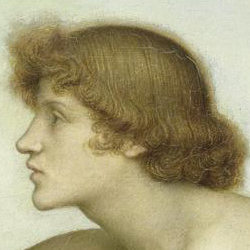

In [ ]:
test = cv.cvtColor(cv.imread('test/Phosphorus_and_Hesperus.png'), cv.COLOR_BGR2RGB)
result = image_color(test)
test = Image.fromarray(np.uint8(test))
result = Image.fromarray(np.uint8(result))

test

In [ ]:
result.save('Phosphorus_and_Hesperus_UNet.png')